### Pacotes

In [1]:
# Pacote Módulos
import sys
sys.path.append('modulos')
from tools import *
from data_load import *

In [3]:
# Imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

tensorflow: 2.3.1
numpy     : 1.18.5
sys       : 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
lime      : 0.2.0.1
seaborn   : 0.11.2
pandas    : 1.0.3
matplotlib: 3.3.4
cv2       : 4.2.0
skimage   : 0.19.1



In [5]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
tf_device ='/gpu:0'

### Carregando e Compreendendo os Dados

In [8]:
# Pasta base dos dados
basedir = "/media/datasets/IAMED/Cap06/dados/" 

In [9]:
# Classes das imagens
ausente, presente = obtem_caminho_imagens(basedir)

In [10]:
# Total de imagens
len(ausente + presente)

253

In [11]:
# Imagens da classe positiva
len(presente)

155

In [12]:
# Imagens da classe negativa
len(ausente)

98

In [13]:
# Obtendo as imagens da classe positiva (testando a função)
dados_tumores = carrega_imagens(presente)

In [14]:
len(dados_tumores)

155

### Divisão em Dados de Treino, Teste e Validação

In [15]:
# Parâmetros para divisão dos dados
train_size = 0.70 
test_size = 0.15 
val_size = 0.15 

In [16]:
# Tamamho dos dados de teste para oo segundo split
test_size2 = test_size / (1-train_size)
test_size2

0.4999999999999999

In [17]:
# Split das imagens de tumor ausente em treino e teste
treino_ausente, teste_ausente = train_test_split(ausente, 
                                                 train_size = train_size, 
                                                 random_state = 2021)

In [18]:
# Split das imagens de tumor ausente em teste e validação
teste_ausente, valid_ausente = train_test_split(teste_ausente, 
                                                train_size = test_size2, 
                                                random_state = 2021)

In [19]:
# Split das imagens de tumor presente em treino e teste
treino_presente, teste_presente = train_test_split(presente, 
                                                   train_size = train_size, 
                                                   random_state = 2021)

In [20]:
# Split das imagens de tumor presente em teste e validação
teste_presente, valid_presente = train_test_split(teste_presente, 
                                                  train_size = test_size2, 
                                                  random_state = 2021)

In [21]:
print(f'''
Dados de Treino com Tumor Presente: {len(treino_presente)}
Dados de Teste com Tumor Presente: {len(teste_presente)}
Dados de Validação com Tumor Presente: {len(valid_presente)}
''')


Dados de Treino com Tumor Presente: 108
Dados de Teste com Tumor Presente: 23
Dados de Validação com Tumor Presente: 24



In [22]:
print(f'''
Dados de Treino com Tumor Ausente: {len(treino_ausente)}
Dados de Teste com Tumor Ausente: {len(teste_ausente)}
Dados de Validação com Tumor Ausente: {len(valid_ausente)}
''')


Dados de Treino com Tumor Ausente: 68
Dados de Teste com Tumor Ausente: 14
Dados de Validação com Tumor Ausente: 16



In [23]:
# Combinamos os datasets
dados_treino = treino_ausente
dados_treino.extend(treino_presente)

dados_teste = teste_ausente
dados_teste.extend(teste_presente)

dados_valid = valid_ausente
dados_valid.extend(valid_presente)

In [24]:
# Então carregamos as imagens na memória.

imagens_treino = carrega_imagens(dados_treino)
imagens_treino_len = len(imagens_treino)

imagens_valid = carrega_imagens(dados_valid)
imagens_valid_len = len(imagens_valid)

imagens_teste = carrega_imagens(dados_teste)
imagens_teste_len = len(imagens_teste)

In [25]:
print(f'''
Total de Imagens de Treino: {imagens_treino_len}
Total de Imagens de Validação: {imagens_valid_len}
Total de Imagens de Teste: {imagens_teste_len}
''')


Total de Imagens de Treino: 176
Total de Imagens de Validação: 40
Total de Imagens de Teste: 37



### Removendo Imagens Duplicadas

In [26]:
img1 = imagens_valid[0]
img2 = imagens_valid[1]
img3 = imagens_valid[0]

In [27]:
# Comparação das Imagens
(img1[0] == img2[0]).all()

False

In [28]:
# Comparação das Imagens
(img1[0] == img3[0]).all()

True

In [29]:
# Remove duplicatas
imagens_treino_unicas, imagens_treino_duplicatas = remove_duplicatas(imagens_treino)
imagens_valid_unicas, imagens_valid_duplicatas = remove_duplicatas(imagens_valid)
imagens_teste_unicas, imagens_teste_duplicatas = remove_duplicatas(imagens_teste)

Duplicata encontrada:[[3 3 3]] e [[3 3 3]]
Duplicata encontrada:[[10 10 10]] e [[10 10 10]]
Duplicata encontrada:[[0 0 0]] e [[0 0 0]]
Duplicata encontrada:[[2 2 2]] e [[2 2 2]]
Duplicata encontrada:[[10 10 10]] e [[10 10 10]]
Duplicata encontrada:[[1 1 1]] e [[1 1 1]]
Duplicata encontrada:[[0 0 0]] e [[0 0 0]]
Duplicata encontrada:[[0 0 0]] e [[0 0 0]]
Duplicata encontrada:[[0 0 0]] e [[0 0 0]]
Duplicata encontrada:[[11 11 11]] e [[11 11 11]]
Duplicata encontrada:[[251 251 251]] e [[251 251 251]]
Duplicata encontrada:[[2 2 2]] e [[2 2 2]]


In [30]:
len(imagens_treino_unicas)

165

In [31]:
len(imagens_treino)

176

In [32]:
len(imagens_valid_unicas)

39

In [33]:
len(imagens_valid)

40

In [34]:
len(imagens_teste_unicas)

37

In [35]:
len(imagens_teste)

37

### Visualização das Imagens

In [36]:
labels = ['Tumor Ausente', 'Tumor Presente']

(-0.5, 149.5, 149.5, -0.5)

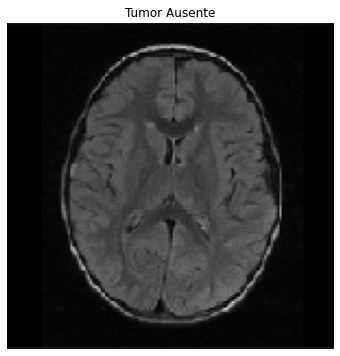

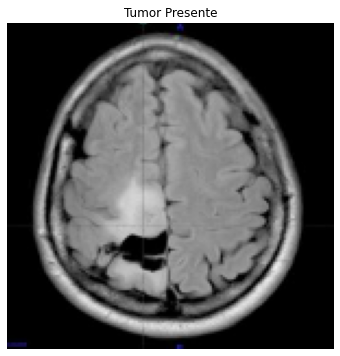

In [37]:
# Plot de imagem com tumor ausente
plt.figure(figsize = (6,6))
plt.imshow(imagens_treino_unicas[0][0], cmap = 'gray')
plt.title(labels[imagens_treino_unicas[0][1]])
plt.axis('off')

# Plot de imagem com tumor presente
plt.figure(figsize = (6,6))
plt.imshow(imagens_treino_unicas[-1][0], cmap = 'gray')
plt.title(labels[imagens_treino_unicas[-1][1]])
plt.axis('off')

### Pré-Processamento

In [38]:
# Listas para os dados no formato final
x_treino = []
y_treino = []

x_valid = []
y_valid = []

x_teste = []
y_teste = []

In [39]:
# Separamos as imagens e os labels
for data, label, _ in imagens_treino_unicas:
    x_treino.append(data)
    y_treino.append(label)
    
for data, label, _ in imagens_valid_unicas:
    x_valid.append(data)
    y_valid.append(label)
    
for data, label, _ in imagens_teste_unicas:
    x_teste.append(data)
    y_teste.append(label)

In [40]:
type(x_treino)

list

In [41]:
# Aplicamos escala aos dados e convertemos para tipo array

x_treino = np.array(x_treino) / 255

x_valid = np.array(x_valid) /  255

x_teste = np.array(x_teste) / 255

In [42]:
type(x_treino)

numpy.ndarray

Por fim, o reshape para deixar os dados no formato esperado pelo modelo.

In [43]:
x_treino.shape

(165, 150, 150, 3)

In [44]:
# Gerador de dados (Visão Computacional)
datagen = ImageDataGenerator(featurewise_center = False,
                             samplewise_center = False,
                             featurewise_std_normalization = False,
                             samplewise_std_normalization = False, 
                             zca_whitening = False, 
                             rotation_range = 30,
                             zoom_range = 0.25,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = False)

### Construção do Modelo

In [47]:
# Cria a sequência de camadas
modelo = Sequential()

In [48]:
# Adiciona a camada de convolução
modelo.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (150,150,3)))

In [49]:
# Adiciona a camada Flatten para converter a saída da convolução
modelo.add(Flatten())

In [50]:
# Camada densa será a última para classificação
modelo.add(Dense(units = 1, activation = 'sigmoid'))

In [51]:
# Cria o otimizador
otimizador = Adam(lr = 0.00001)

# Compilação do modelo
modelo.compile(optimizer = otimizador, 
              loss = 'binary_crossentropy', 
              metrics = ['Precision', 'accuracy'])

In [52]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
flatten (Flatten)            (None, 720000)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 720001    
Total params: 720,897
Trainable params: 720,897
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Redução da taxa de aprendizado à medida que alcançar um plateau no treinamento na taxa de erro
learning_rate_reduction_loss = ReduceLROnPlateau(monitor = 'val_loss', 
                                                 patience = 3, 
                                                 verbose = 1, 
                                                 factor = 0.3,
                                                 mode = 'min',
                                                 min_lr = 0.000001)

In [54]:
checkpoint = ModelCheckpoint('modelo/modelo.h5', 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'min')

### Treinamento do Modelo

In [57]:
# Hiperparâmetro
num_epochs = 40

In [58]:
%%time
history = modelo.fit(datagen.flow(x_treino, y_treino), 
                     epochs = num_epochs, 
                     validation_data = datagen.flow(x_valid, y_valid), 
                     callbacks = [learning_rate_reduction_loss, checkpoint])

Epoch 1/40


2022-08-03 06:35:15.120536: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-03 06:35:15.259808: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


5/6 [========================>.....] - ETA: 0s - loss: 0.6392 - precision: 0.6377 - accuracy: 0.6187
Epoch 00001: val_loss improved from inf to 0.67066, saving model to modelo/modelo.h5
6/6 [==============================] - 1s 150ms/step - loss: 0.6428 - precision: 0.6364 - accuracy: 0.6182 - val_loss: 0.6707 - val_precision: 0.6154 - val_accuracy: 0.6154
Epoch 2/40
5/6 [========================>.....] - ETA: 0s - loss: 0.6742 - precision: 0.6125 - accuracy: 0.6125
Epoch 00002: val_loss improved from 0.67066 to 0.65214, saving model to modelo/modelo.h5
6/6 [==============================] - 1s 114ms/step - loss: 0.6707 - precision: 0.6182 - accuracy: 0.6182 - val_loss: 0.6521 - val_precision: 0.6154 - val_accuracy: 0.6154
Epoch 3/40
5/6 [========================>.....] - ETA: 0s - loss: 0.6374 - precision: 0.6250 - accuracy: 0.6250
Epoch 00003: val_loss improved from 0.65214 to 0.63453, saving model to modelo/modelo.h5
6/6 [==============================] - 1s 115ms/step - loss: 0.640

Epoch 25/40
6/6 [==============================] - ETA: 0s - loss: 0.6006 - precision: 0.6456 - accuracy: 0.6606
Epoch 00025: val_loss improved from 0.61293 to 0.60641, saving model to modelo/modelo.h5
6/6 [==============================] - 1s 111ms/step - loss: 0.6006 - precision: 0.6456 - accuracy: 0.6606 - val_loss: 0.6064 - val_precision: 0.6154 - val_accuracy: 0.6154
Epoch 26/40
6/6 [==============================] - ETA: 0s - loss: 0.6363 - precision: 0.6415 - accuracy: 0.6545
Epoch 00026: val_loss did not improve from 0.60641
6/6 [==============================] - 1s 110ms/step - loss: 0.6363 - precision: 0.6415 - accuracy: 0.6545 - val_loss: 0.6443 - val_precision: 0.5946 - val_accuracy: 0.5641
Epoch 27/40
6/6 [==============================] - ETA: 0s - loss: 0.6200 - precision: 0.6369 - accuracy: 0.6424
Epoch 00027: val_loss improved from 0.60641 to 0.60487, saving model to modelo/modelo.h5
6/6 [==============================] - 1s 128ms/step - loss: 0.6200 - precision: 0.636

### Avaliação do Modelo

In [58]:
# Carregamos o modelo treinado
model =  tf.keras.models.load_model('modelo/modelo.h5')

In [59]:
y_teste = np.array(y_teste, dtype = np.uint8)

In [60]:
model.evaluate(x_teste, y_teste)

2/2 [==============================] - 0s 2ms/step - loss: 0.5638 - precision_1: 0.6571 - accuracy: 0.6757


[0.56381756067276, 0.6571428775787354, 0.6756756901741028]

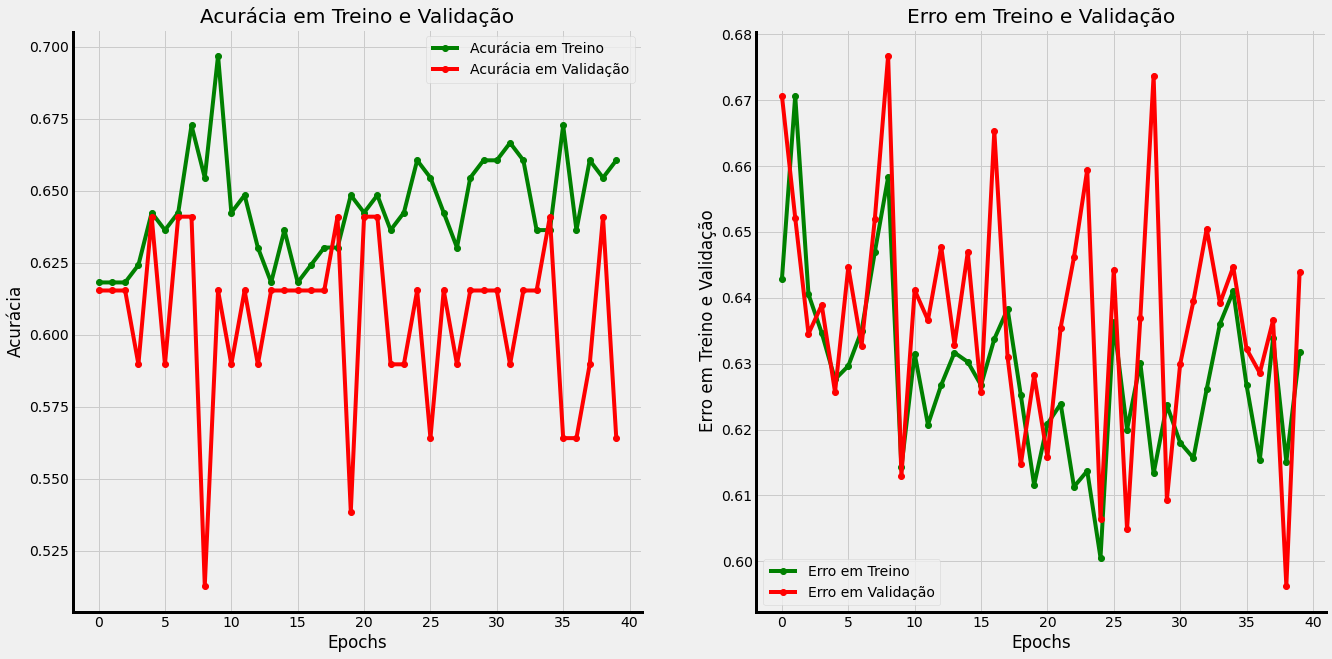

In [62]:
# Range de épocas
epochs = [i for i in range(40)]

# Parâmetros dos plots
plt.style.use('fivethirtyeight')
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.facecolor'] = 'F0F0F0'

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Acurácia em Treino')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurácia em Validação')
ax[0].set_title('Acurácia em Treino e Validação')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Acurácia")
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].tick_params(axis='x', colors='black')
ax[0].tick_params(axis='y', colors='black')
ax[0].yaxis.label.set_color('black')
ax[0].xaxis.label.set_color('black')

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Erro em Treino')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Erro em Validação')
ax[1].set_title('Erro em Treino e Validação')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Erro em Treino e Validação")
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].tick_params(axis='x', colors='black')
ax[1].tick_params(axis='y', colors='black')
ax[1].yaxis.label.set_color('black')
ax[1].xaxis.label.set_color('black')
plt.savefig('reports/fig', transparent = True, dpi = 150)
plt.show()

### Previsões com o Modelo Treinado

In [61]:
# Previsões do modelo com valores binários e limite de 0.5
(model.predict(x_teste) > 0.5).astype('int32')[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1]], dtype=int32)

                           precision    recall  f1-score   support

 Tumor Ausente (Classe 0)       0.39      0.93      0.55        14
Tumor Presente (Classe 1)       0.75      0.13      0.22        23

                 accuracy                           0.43        37
                macro avg       0.57      0.53      0.39        37
             weighted avg       0.62      0.43      0.35        37

[[13  1]
 [20  3]]


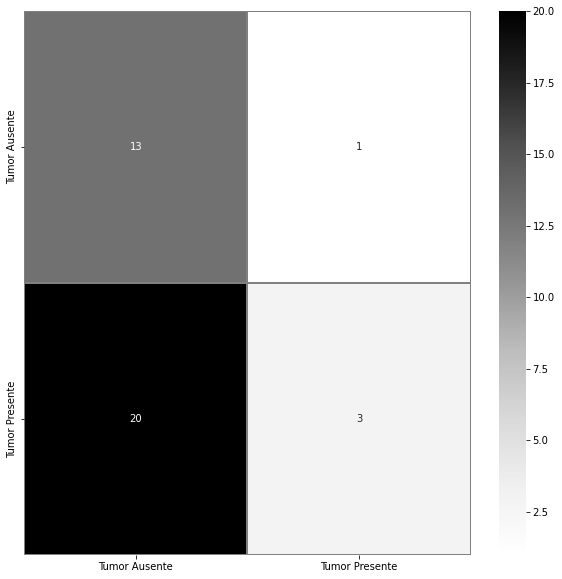

In [62]:
# Matriz de confusão
plot_confusion_matrix(modelo, x_teste, y_teste)

### Interpretação com LIME

In [63]:
y_treino[106]

1

In [64]:
x_treino[106]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

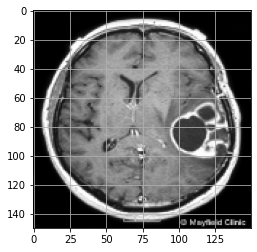

In [65]:
plt.imshow(x_treino[106])
plt.grid(b = None)
plt.savefig('reports/106', transparent = True, dpi = 150)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

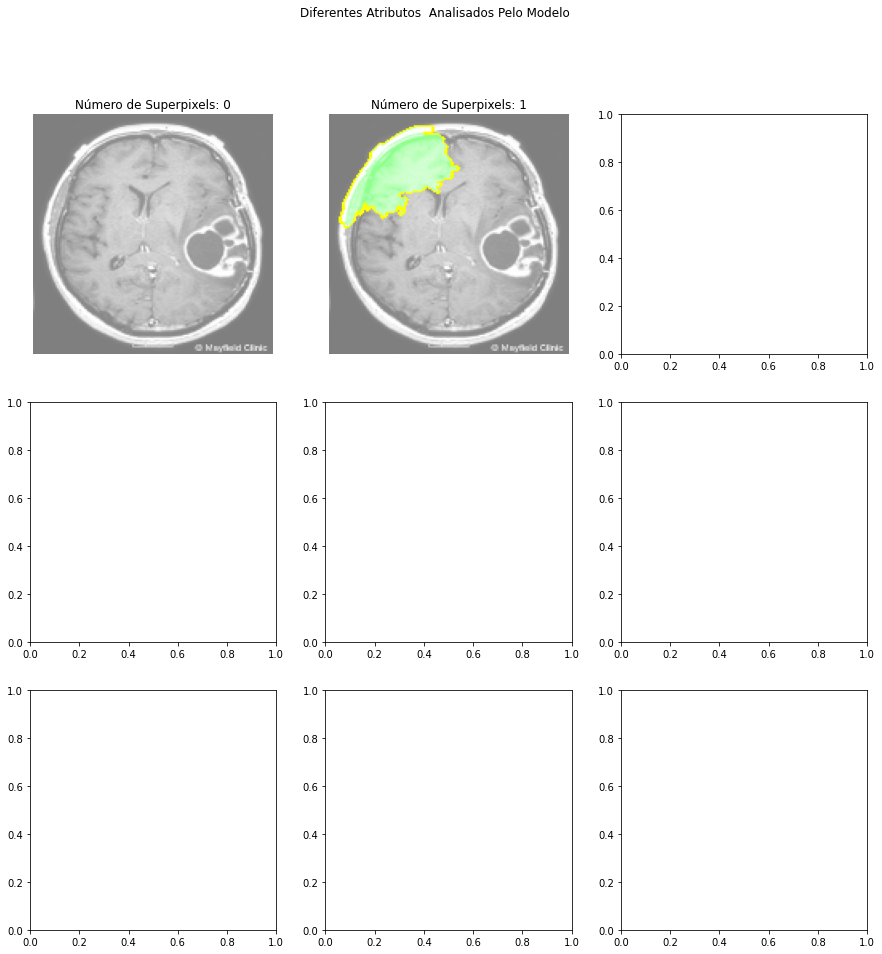

In [66]:
lime_image(model, x_treino[106], min_superpixels  = 0, max_superpixels = 2, title = 'lime2' )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

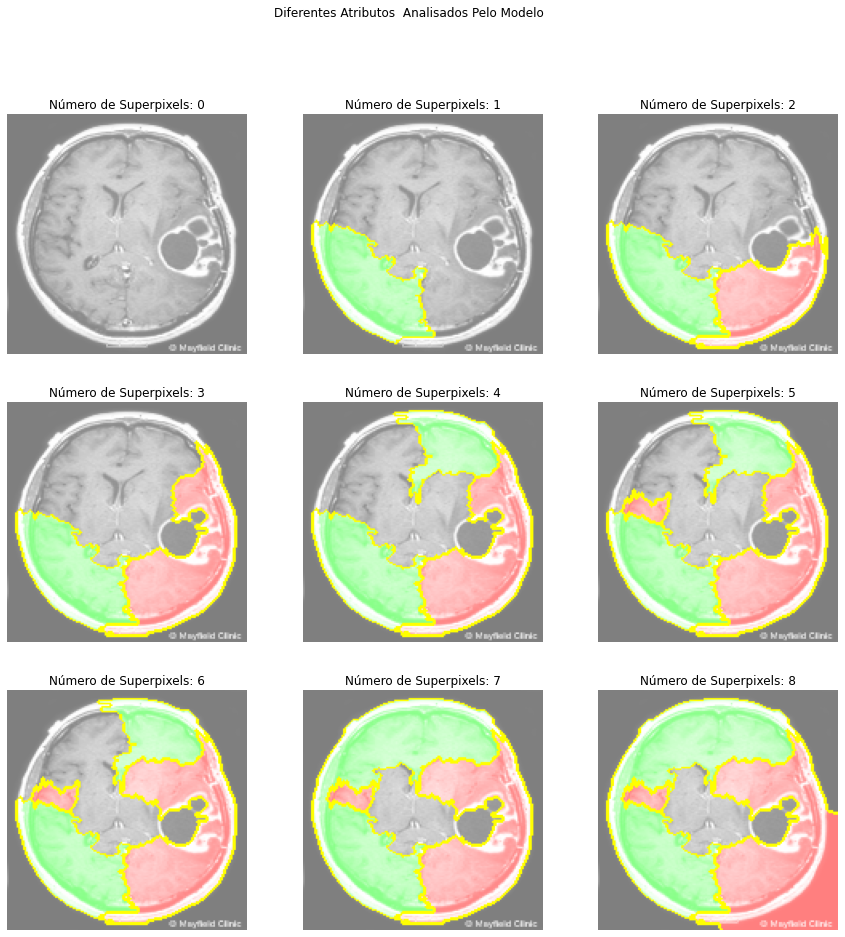

In [67]:
lime_image(modelo, x_treino[106], min_superpixels = 0, max_superpixels = 9 )